In [75]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
from arch import arch_model

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline

In [77]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [78]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Выберем временной ряд - нестационарный до преобразований (series).

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


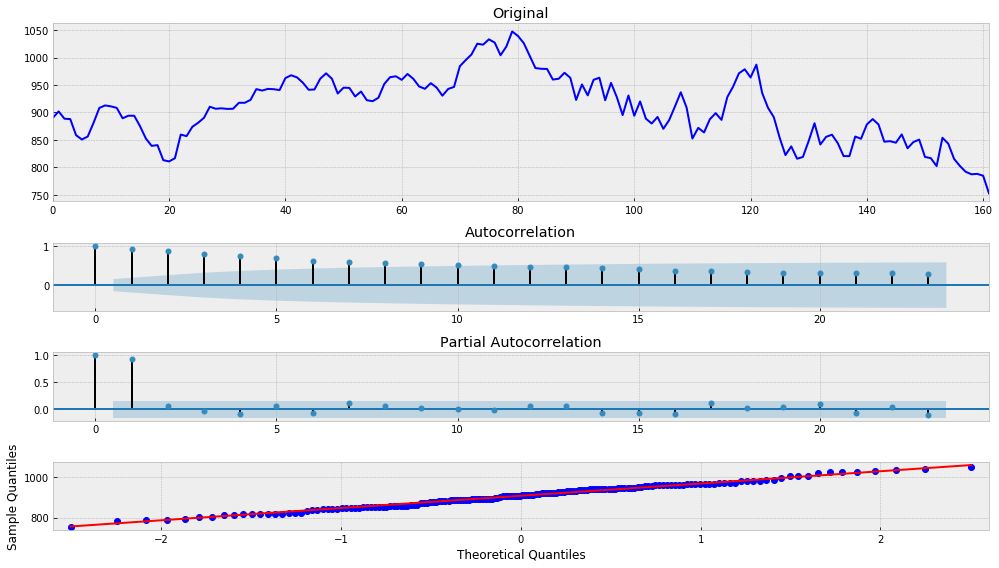

In [79]:
series = pd.read_csv("weekly-closings-of-the-dowjones-.csv")["Close"].values.astype('float64')
tsplot(series)

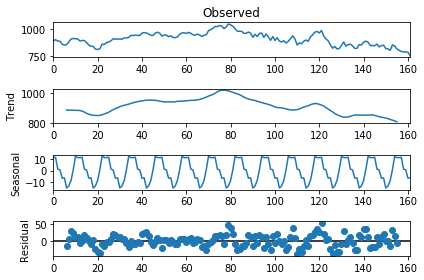

In [80]:
from statsmodels.tsa.seasonal import seasonal_decompose  
result = seasonal_decompose(series, period = 12, model='add')
result.plot();

Попробуем найти наилучшие параметры

In [81]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

aic, order, mdl = _get_best_model(series)

/Users/svetlana/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
/Users/svetlana/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/svetlana/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/svetlana/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/svetlana/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


aic: 1416.27670 | order: (2, 2, 3)


Попробуем подобрать значение порядка через grid search

In [82]:
from pmdarima import auto_arima

In [86]:
stepwise_fit = auto_arima(series, start_p = 0, start_d = 0, start_q = 0, max_p=4, max_d=4, max_q = 4, 
                          seasonal = True, trace = True)

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1422.147, BIC=1428.310, Time=0.018 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1423.867, BIC=1433.111, Time=0.060 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=1423.877, BIC=1433.121, Time=0.048 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=1420.447, BIC=1423.529, Time=0.011 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=1425.858, BIC=1438.184, Time=0.202 seconds
Total fit time: 0.346 seconds


In [87]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  162
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -709.224
Date:                Sun, 10 May 2020   AIC                           1420.447
Time:                        19:52:34   BIC                           1423.529
Sample:                             0   HQIC                          1421.699
                                - 162                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       392.4389     44.934      8.734      0.000     304.371     480.507
===================================================================================
Ljung-Box (Q):                       50.56   Jarque-Bera (JB):                 0.33
Prob(Q):                              0.12   Prob(JB):                         0.85
Heteroskedasticity (H):               2.84   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Попробуем применить ARCH 

In [89]:
am = arch_model(series)
res = am.fit(update_freq=10)
print(res.summary())

Iteration:     10,   Func. Count:     61,   Neg. LLF: 856.3457488275541
Iteration:     20,   Func. Count:    124,   Neg. LLF: 854.1368126880644
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 854.1236892598324
            Iterations: 26
            Function evaluations: 162
            Gradient evaluations: 26
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -854.124
Distribution:                  Normal   AIC:                           1716.25
Method:            Maximum Likelihood   BIC:                           1728.60
                                        No. Observations:                  162
Date:                Sun, May 10 2020   Df Residuals:                      158
Time:        